# Tardiness

- Tardiness = 0, wenn der Auftrag rechtzeitig oder sogar vorzeitig fertiggestellt wurde.
- Tardiness > 0, wenn der Auftrag später fertiggestellt wird als ursprünglich vorgesehen
- berücksichtigt nur positive Abweichungen, also nur tatsächliche Verspätungen.

$$
T_j = \max(0,\; C_j - d_j)
$$


- $T_j$: Tardiness (Verspätung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $T_j > 0$: Job ist **verspätet**  
- $T_j = 0$: Job ist **pünktlich oder zu früh**  
- Frühfertigungen werden **nicht bestraft**, sondern zu $0$ gesetzt

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check
from src.utils.production_process import initialize as init
from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tardiness
import src.models.heuristics.fcfs as fcfs

# Extern
import pandas as pd
pd.set_option('display.max_rows', 16)

In [2]:
max_time = 60 * 5 # 5 min

In [4]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")
df_routings

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.94, shuffle = True,
                                                        job_seed=40, arrival_seed=80
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,9,49,1440
1,J25-0001,5,130,1440
2,J25-0002,3,151,1440
3,J25-0003,4,226,1440
4,J25-0004,6,386,1440
...,...,...,...,...
15,J25-0015,5,1142,1440
16,J25-0016,6,1254,1440
17,J25-0017,7,1285,1440
18,J25-0018,8,1397,1440


In [5]:
df_jobs_times = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times


Schedule-Informationen:
  Makespan: 2319


,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J25-0000,9,49,1440,1109.0
1,J25-0001,5,130,1440,1104.0
2,J25-0002,3,151,1440,1437.0
3,J25-0003,4,226,1440,998.0
4,J25-0004,6,386,1440,1203.0
...,...,...,...,...,...
15,J25-0015,5,1142,1440,2116.0
16,J25-0016,6,1254,1440,2071.0
17,J25-0017,7,1285,1440,2343.0
18,J25-0018,8,1397,1440,2569.0


In [7]:
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,9,0,M01,85
1,J25-0000,9,1,M00,13
2,J25-0000,9,2,M02,61
3,J25-0000,9,3,M06,7
4,J25-0000,9,4,M08,64
...,...,...,...,...,...
195,J25-0019,9,5,M09,76
196,J25-0019,9,6,M05,47
197,J25-0019,9,7,M03,52
198,J25-0019,9,8,M04,90


## a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$  
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**  
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [6]:
# Scheduling
df_schedule = lp_tardiness.solve_jssp_sum(df_jssp, df_jobs_times, solver= "HiGHS",
                                          msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule


Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2140
  Anzahl Constraints      : 4020
  Laufzeit                : ~86 Sekunden


,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,0,M01,85,9,49,1440,1109.0,268.0,353.0,0.0
1,J25-0000,1,M00,13,9,49,1440,1109.0,353.0,366.0,0.0
2,J25-0000,2,M02,61,9,49,1440,1109.0,366.0,427.0,0.0
3,J25-0000,3,M06,7,9,49,1440,1109.0,472.0,479.0,0.0
4,J25-0000,4,M08,64,9,49,1440,1109.0,479.0,543.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
195,J25-0019,5,M09,76,9,1398,1440,2458.0,2036.0,2112.0,0.0
196,J25-0019,6,M05,47,9,1398,1440,2458.0,2112.0,2159.0,0.0
197,J25-0019,7,M03,52,9,1398,1440,2458.0,2193.0,2245.0,0.0
198,J25-0019,8,M04,90,9,1398,1440,2458.0,2245.0,2335.0,0.0


In [6]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            20
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


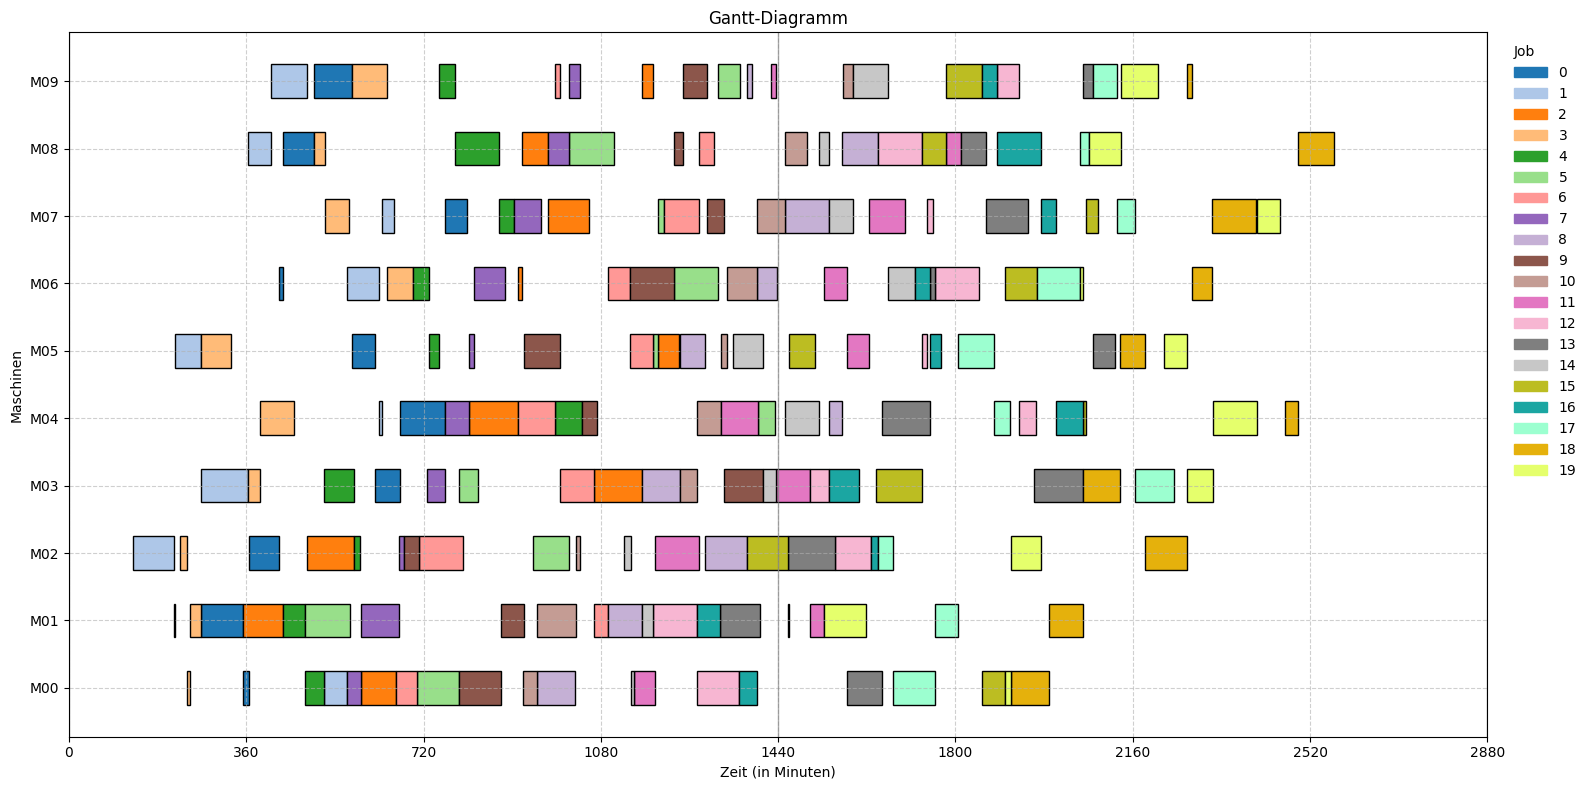

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [7]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$  
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**  
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.


In [8]:
# Scheduling
df_schedule = lp_tardiness.solve_jssp_max(df_jssp, df_jobs_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule


Solver-Informationen:
  Maximale Tardiness      : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2141
  Anzahl Constraints      : 4040
  Laufzeit                : ~42 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,1,5,0,M02,84,130,1440,1104.0,130.0,214.0,0.0
1,1,5,1,M01,2,130,1440,1104.0,214.0,216.0,0.0
2,1,5,2,M05,52,130,1440,1104.0,216.0,268.0,0.0
3,3,4,0,M02,14,226,1440,998.0,226.0,240.0,0.0
4,3,4,1,M00,6,226,1440,998.0,240.0,246.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
195,19,9,8,M04,90,1398,1440,2458.0,2305.0,2395.0,0.0
196,18,8,7,M07,89,1397,1440,2569.0,2323.0,2412.0,0.0
197,18,8,8,M04,26,1397,1440,2569.0,2412.0,2438.0,0.0
198,19,9,9,M07,45,1398,1440,2458.0,2412.0,2457.0,0.0


In [9]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            20
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


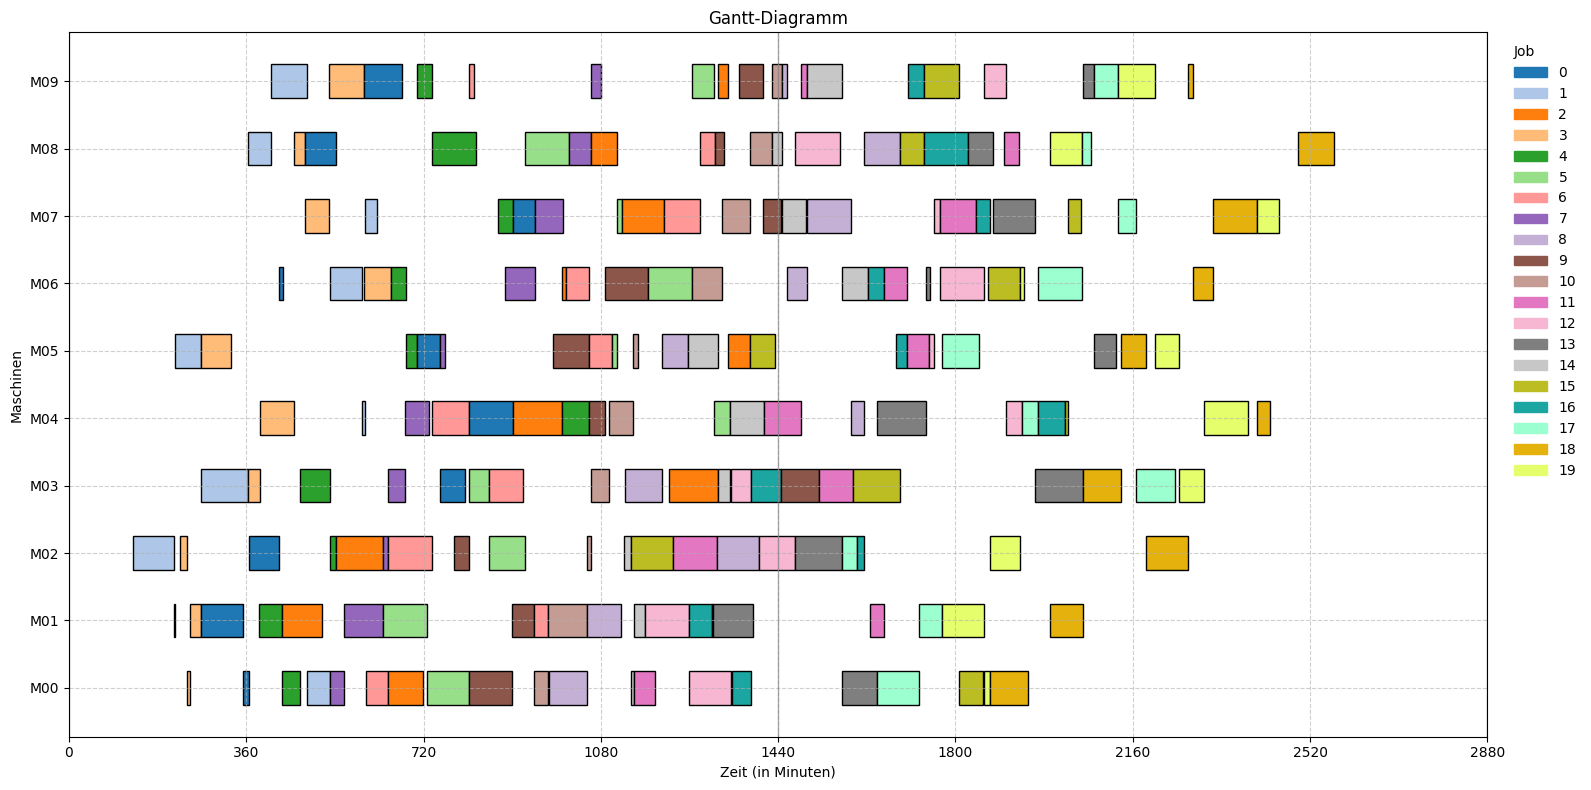

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)